In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import os
import pickle
from PIL import Image
import random
import warnings
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Accuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

C:\Users\Juan\AppData\Local\Temp\ipykernel_24216\4233884648.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Reading dataset as dataframe

df_img = pd.read_csv('./../data/cleaned/ferplus_affectnet.csv')
df_img.head()

,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,...,Pixel_2296,Pixel_2297,Pixel_2298,Pixel_2299,Pixel_2300,Pixel_2301,Pixel_2302,Pixel_2303,Pixel_2304,Label
0,30,24,21,23,25,25,49,67,84,103,...,106,111,148,137,176,174,172,173,173,anger
1,123,125,124,142,209,226,234,236,231,232,...,103,116,111,105,105,103,97,91,89,anger
2,236,230,225,226,228,209,199,193,196,211,...,192,190,186,171,144,144,152,155,173,anger
3,255,82,0,3,0,0,0,0,0,0,...,101,217,255,198,143,236,254,254,254,anger
4,206,208,209,212,214,216,216,219,221,222,...,38,42,50,47,26,31,29,40,5,anger


In [5]:
df_img['Label'].value_counts().sort_values(ascending=False)

Label
neutral      18031
happiness    14399
surprise      8501
sadness       7461
anger         6328
fear          3995
contempt      3087
disgust       2725
Name: count, dtype: int64

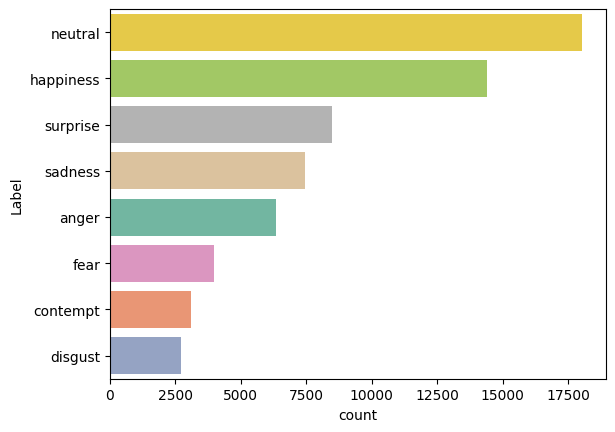

In [6]:
# Checking how many images we have for each label

counts = df_img['Label'].value_counts().sort_values(ascending=False)

sns.countplot(y=df_img['Label'], hue=df_img['Label'], order=counts.index, palette='Set2')
plt.show()

In [7]:
pixel_cols = [col for col in df_img.columns if 'Pixel' in col]

for col in pixel_cols:
    df_img[col].astype(float)

In [8]:
def normalize(value):
    return value/255

In [9]:
df_img.iloc[:, :-1] = df_img.iloc[:, :-1].apply(normalize)

df_img.head()

,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,...,Pixel_2296,Pixel_2297,Pixel_2298,Pixel_2299,Pixel_2300,Pixel_2301,Pixel_2302,Pixel_2303,Pixel_2304,Label
0,0.117647,0.094118,0.082353,0.090196,0.098039,0.098039,0.192157,0.262745,0.329412,0.403922,...,0.415686,0.435294,0.580392,0.537255,0.690196,0.682353,0.674510,0.678431,0.678431,anger
1,0.482353,0.490196,0.486275,0.556863,0.819608,0.886275,0.917647,0.925490,0.905882,0.909804,...,0.403922,0.454902,0.435294,0.411765,0.411765,0.403922,0.380392,0.356863,0.349020,anger
2,0.925490,0.901961,0.882353,0.886275,0.894118,0.819608,0.780392,0.756863,0.768627,0.827451,...,0.752941,0.745098,0.729412,0.670588,0.564706,0.564706,0.596078,0.607843,0.678431,anger
3,1.000000,0.321569,0.000000,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.396078,0.850980,1.000000,0.776471,0.560784,0.925490,0.996078,0.996078,0.996078,anger
4,0.807843,0.815686,0.819608,0.831373,0.839216,0.847059,0.847059,0.858824,0.866667,0.870588,...,0.149020,0.164706,0.196078,0.184314,0.101961,0.121569,0.113725,0.156863,0.019608,anger


In [10]:
labels = df_img['Label'].unique().tolist()

mapping_dict = dict(zip(labels, range(8)))

df_img['Label'] = df_img['Label'].replace(mapping_dict)

df_img['Label'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [11]:
# Splitting dataset into X and y

X = df_img.drop(columns='Label')
y = df_img['Label']

In [12]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51621, 2304), (12906, 2304), (51621,), (12906,))

In [30]:
# Converting train and test dfs to numpy arrays

X_train_np = np.array(X_train).reshape((-1, 48, 48, 1))
y_train_np = np.array(y_train)
X_test_np = np.array(X_test).reshape((-1, 48, 48, 1))
y_test_np = np.array(y_test)

input_shape = (48, 48, 1)

In [32]:
from keras.regularizers import l2

model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation="selu", padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation="selu", padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), activation="selu", padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3,3), activation="selu", padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), activation="selu", padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (3,3), activation="selu", padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3,3), activation="selu", padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 24, 24, 64)      

In [34]:
# Compiling + fitting

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(X_train_np, y_train_np, epochs=10, batch_size=32, validation_split=0.2, verbose=2, callbacks=[EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')])

Epoch 1/10
1291/1291 - 15s - loss: 2.4004 - accuracy: 0.4226 - val_loss: 1.6536 - val_accuracy: 0.4849 - lr: 0.0010 - 15s/epoch - 11ms/step
Epoch 2/10
1291/1291 - 11s - loss: 1.4578 - accuracy: 0.5535 - val_loss: 1.4053 - val_accuracy: 0.5608 - lr: 0.0010 - 11s/epoch - 9ms/step
Epoch 3/10
1291/1291 - 11s - loss: 1.3369 - accuracy: 0.5942 - val_loss: 1.2867 - val_accuracy: 0.6087 - lr: 0.0010 - 11s/epoch - 9ms/step
Epoch 4/10
1291/1291 - 10s - loss: 1.2594 - accuracy: 0.6239 - val_loss: 1.2606 - val_accuracy: 0.6143 - lr: 0.0010 - 10s/epoch - 8ms/step
Epoch 5/10
1291/1291 - 11s - loss: 1.2056 - accuracy: 0.6442 - val_loss: 1.1925 - val_accuracy: 0.6512 - lr: 0.0010 - 11s/epoch - 9ms/step
Epoch 6/10
1291/1291 - 12s - loss: 1.1592 - accuracy: 0.6638 - val_loss: 1.1247 - val_accuracy: 0.6686 - lr: 0.0010 - 12s/epoch - 9ms/step
Epoch 7/10
1291/1291 - 11s - loss: 1.1206 - accuracy: 0.6801 - val_loss: 1.1095 - val_accuracy: 0.6765 - lr: 0.0010 - 11s/epoch - 9ms/step
Epoch 8/10
1291/1291 - 11s

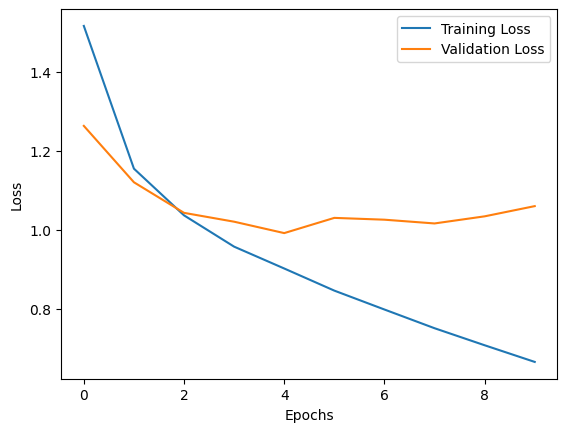

In [18]:
# Plotting train and val losses

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Saving model

# directory_path = r'C:\Users\Juan\Documents\Ironhack\Week_9\ih-final-project\models'

# if not os.path.exists(directory_path):
#     os.makedirs(directory_path)

# file_path = os.path.join(directory_path, 'model1.h5')
# model.save(file_path)

In [35]:
# Making predictions for the test set

y_pred_proba = model.predict(X_test_np)

y_pred = [np.argmax(x) for x in y_pred_proba]

y_pred

404/404 [==============================] - 1s 3ms/step


[4,
 5,
 0,
 7,
 0,
 7,
 1,
 0,
 5,
 4,
 6,
 4,
 4,
 6,
 7,
 5,
 0,
 5,
 7,
 7,
 0,
 0,
 0,
 4,
 5,
 6,
 5,
 5,
 5,
 5,
 4,
 7,
 5,
 6,
 0,
 7,
 4,
 4,
 5,
 4,
 1,
 5,
 6,
 5,
 0,
 3,
 0,
 4,
 5,
 7,
 1,
 4,
 4,
 5,
 0,
 6,
 7,
 4,
 5,
 7,
 1,
 0,
 1,
 4,
 7,
 5,
 5,
 4,
 0,
 5,
 5,
 5,
 7,
 2,
 0,
 4,
 5,
 5,
 4,
 5,
 4,
 5,
 5,
 4,
 7,
 4,
 2,
 5,
 0,
 0,
 0,
 7,
 0,
 5,
 0,
 3,
 5,
 5,
 5,
 7,
 4,
 5,
 5,
 0,
 5,
 2,
 5,
 4,
 5,
 5,
 5,
 4,
 5,
 5,
 1,
 5,
 5,
 5,
 5,
 3,
 4,
 5,
 0,
 5,
 7,
 5,
 5,
 5,
 5,
 4,
 7,
 1,
 5,
 4,
 6,
 4,
 5,
 7,
 4,
 0,
 5,
 5,
 6,
 1,
 5,
 7,
 7,
 7,
 7,
 5,
 5,
 7,
 5,
 3,
 0,
 7,
 5,
 4,
 5,
 0,
 2,
 6,
 5,
 5,
 4,
 6,
 3,
 5,
 5,
 5,
 4,
 4,
 4,
 5,
 7,
 5,
 0,
 4,
 7,
 3,
 5,
 7,
 5,
 7,
 7,
 4,
 0,
 7,
 0,
 7,
 4,
 6,
 5,
 3,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 0,
 5,
 5,
 0,
 5,
 4,
 5,
 5,
 4,
 5,
 0,
 4,
 0,
 5,
 5,
 5,
 7,
 5,
 5,
 6,
 7,
 5,
 4,
 4,
 5,
 0,
 0,
 3,
 7,
 5,
 5,
 0,
 5,
 7,
 3,
 0,
 4,
 4,
 5,
 0,
 1,
 2,
 2,
 5,
 5,
 5,
 5,
 5,


Classification report:
              precision    recall  f1-score   support

           0       0.68      0.52      0.59      1657
           1       0.56      0.57      0.57       607
           2       0.23      0.43      0.30       287
           3       0.39      0.50      0.44       619
           4       0.85      0.89      0.87      2776
           5       0.86      0.72      0.78      4323
           6       0.35      0.63      0.45       830
           7       0.69      0.65      0.67      1807

    accuracy                           0.69     12906
   macro avg       0.58      0.61      0.58     12906
weighted avg       0.73      0.69      0.70     12906

Cohen-Kappa score: 0.6194290258157841


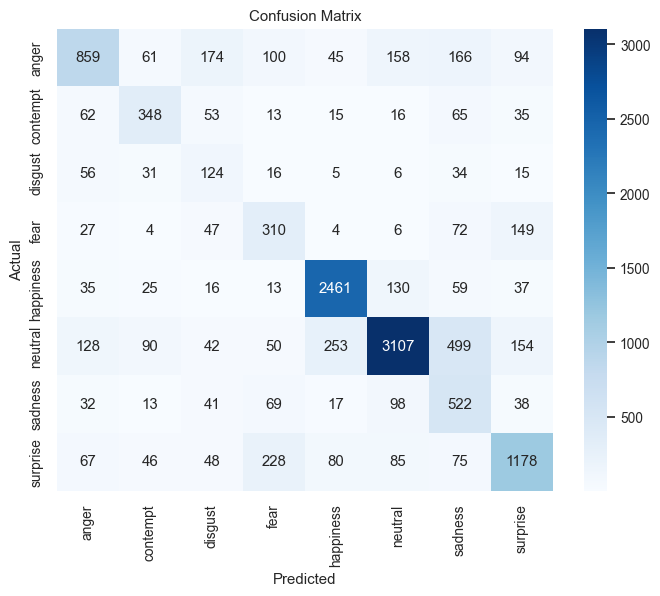

In [36]:
# Performance metrics on test set

cr = classification_report(y_pred, y_test)
print(f'Classification report:\n{cr}')

chs = cohen_kappa_score(y_pred, y_test)
print(f'Cohen-Kappa score: {chs}')

cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(8, 6))
sns.set(font_scale=0.9)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

In [21]:
# Creating a more complex model

model2 = models.Sequential()

# Convolutional layers
model2.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(48, 48, 1)))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))

model2.add(layers.Conv2D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(layers.BatchNormalization())

model2.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu'))

model2.add(layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
model2.add(layers.BatchNormalization())

model2.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu'))

model2.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.BatchNormalization())

model2.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
# model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(512, kernel_size=3, strides=2, padding='same', activation='relu'))
model2.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.BatchNormalization())

# Flattening + dense layers with dropout
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.2))
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.BatchNormalization())

# Output layer
model2.add(layers.Dense(8, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 32)       

In [25]:
from keras.utils import to_categorical

# Assuming y_train_np contains integer class indices
y_train_one_hot = to_categorical(y_train_np, num_classes=8)

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(X_train_np, y_train_one_hot, epochs=50, batch_size=32, validation_split=0.2, verbose=2, callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard])

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.34942, saving model to best_model.h5
710/710 - 16s - loss: 1.8330 - accuracy: 0.3166 - val_loss: 1.6692 - val_accuracy: 0.3494 - lr: 0.0010 - 16s/epoch - 23ms/step
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.34942
710/710 - 12s - loss: 1.6777 - accuracy: 0.3322 - val_loss: 1.6966 - val_accuracy: 0.3330 - lr: 0.0010 - 12s/epoch - 17ms/step
Epoch 3/50

Epoch 3: val_accuracy did not improve from 0.34942
710/710 - 12s - loss: 1.6553 - accuracy: 0.3399 - val_loss: 1.6253 - val_accuracy: 0.3389 - lr: 0.0010 - 12s/epoch - 17ms/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.34942
710/710 - 12s - loss: 1.6368 - accuracy: 0.3419 - val_loss: 1.6130 - val_accuracy: 0.3364 - lr: 0.0010 - 12s/epoch - 17ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.34942 to 0.35893, saving model to best_model.h5
710/710 - 12s - loss: 1.6142 - accuracy: 0.3567 - val_loss: 1.6508 - val_accuracy: 0.3589 - lr: 0.0010 - 12s/e

In [24]:
y_train_np

array([5, 5, 4, ..., 4, 4, 0], dtype=int64)

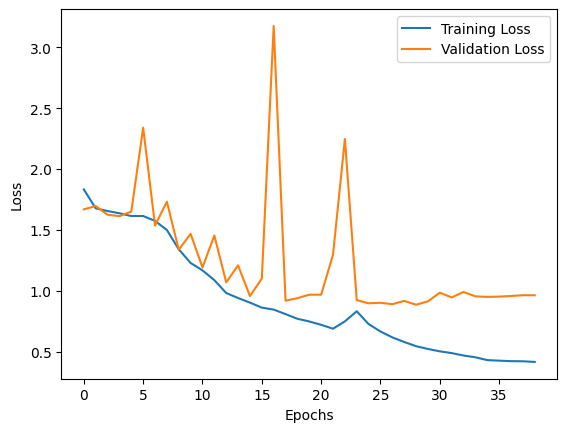

In [27]:
# Plotting train and val losses

plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# Saving model

directory_path = r'C:\Users\Juan\Documents\Ironhack\Week_9\ih-final-project\models'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)

file_path = os.path.join(directory_path, 'model2.h5')
model.save(file_path)

In [29]:
# Making predictions for the test set

y_pred_proba2 = model2.predict(X_test_np)

y_pred2 = [np.argmax(x) for x in y_pred_proba2]

y_pred2

222/222 [==============================] - 2s 6ms/step


[4,
 0,
 0,
 5,
 5,
 5,
 5,
 0,
 5,
 4,
 5,
 5,
 6,
 5,
 6,
 5,
 6,
 4,
 7,
 0,
 6,
 4,
 4,
 4,
 7,
 0,
 5,
 6,
 0,
 0,
 7,
 7,
 5,
 6,
 4,
 4,
 4,
 0,
 0,
 5,
 4,
 4,
 5,
 0,
 5,
 5,
 7,
 5,
 5,
 4,
 5,
 4,
 6,
 5,
 5,
 5,
 4,
 7,
 4,
 0,
 4,
 5,
 4,
 5,
 5,
 5,
 5,
 4,
 5,
 5,
 6,
 4,
 0,
 5,
 4,
 6,
 4,
 5,
 7,
 0,
 6,
 5,
 5,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 5,
 4,
 0,
 5,
 5,
 0,
 5,
 5,
 5,
 5,
 4,
 5,
 6,
 7,
 5,
 6,
 6,
 5,
 0,
 5,
 5,
 5,
 4,
 7,
 4,
 5,
 4,
 5,
 6,
 7,
 4,
 4,
 5,
 4,
 7,
 5,
 5,
 5,
 6,
 5,
 5,
 6,
 4,
 6,
 5,
 7,
 5,
 0,
 6,
 4,
 6,
 5,
 4,
 5,
 5,
 0,
 6,
 6,
 4,
 4,
 7,
 4,
 5,
 5,
 5,
 5,
 4,
 7,
 6,
 5,
 5,
 6,
 5,
 4,
 4,
 5,
 7,
 7,
 4,
 4,
 6,
 7,
 5,
 5,
 5,
 0,
 5,
 5,
 4,
 5,
 6,
 5,
 5,
 5,
 0,
 7,
 5,
 5,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 7,
 6,
 0,
 4,
 5,
 6,
 5,
 5,
 6,
 7,
 0,
 6,
 0,
 5,
 4,
 0,
 4,
 4,
 5,
 0,
 5,
 6,
 7,
 5,
 0,
 4,
 6,
 5,
 5,
 6,
 6,
 4,
 5,
 5,
 0,
 6,
 6,
 0,
 6,
 7,
 5,
 7,
 7,
 7,
 4,
 4,
 5,
 4,
 6,
 5,
 5,
 4,
 5,


Classification report:
              precision    recall  f1-score   support

           0       0.64      0.53      0.58       753
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.80      0.90      0.85      1652
           5       0.82      0.74      0.78      2884
           6       0.38      0.36      0.37       912
           7       0.78      0.77      0.77       896

    accuracy                           0.71      7097
   macro avg       0.43      0.41      0.42      7097
weighted avg       0.73      0.71      0.72      7097

Cohen-Kappa score: 0.6130948111490646


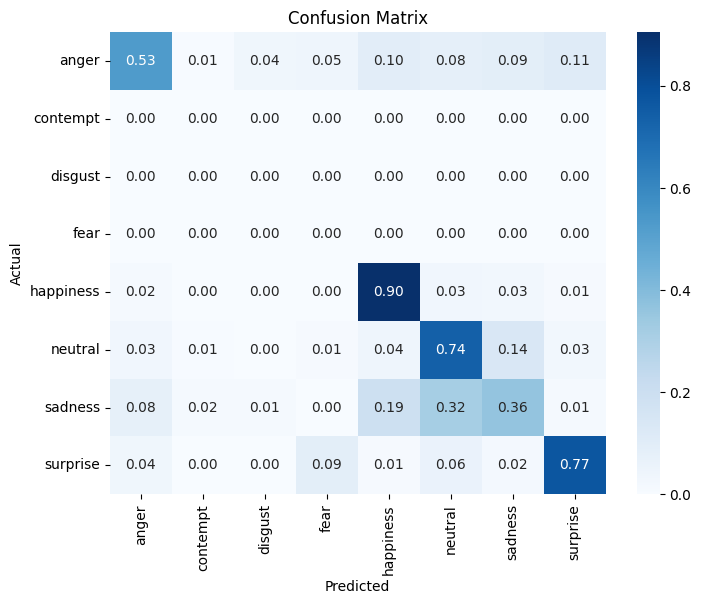

In [30]:
# Performance metrics on test set

cr2 = classification_report(y_pred2, y_test)
print(f'Classification report:\n{cr2}')

chs2 = cohen_kappa_score(y_pred2, y_test)
print(f'Cohen-Kappa score: {chs2}')

cm2 = confusion_matrix(y_pred2, y_test, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Transfer learning with EfficientNet

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freezing pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Adding dense layers on top of EfficientNetB0
model3 = models.Sequential()
model3.add(base_model)
model3.add(layers.GlobalAveragePooling2D())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(8, activation='softmax'))

model3.summary()

In [ ]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history3 = model3.fit(X_train_np, y_train_np, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

In [ ]:
# Plotting train and val losses

plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Saving model

directory_path = r'C:\Users\Juan\Documents\Ironhack\Week_9\ih-final-project\models'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)

file_path = os.path.join(directory_path, 'model3.h5')
model.save(file_path)

In [ ]:
# Making predictions for the test set

y_pred_proba3 = model3.predict(X_test_np)

y_pred3 = [np.argmax(x) for x in y_pred_proba3]

y_pred3

In [ ]:
# Performance metrics on test set

cr3 = classification_report(y_pred3, y_test)
print(f'Classification report:\n{cr3}')

chs3 = cohen_kappa_score(y_pred3, y_test)
print(f'Cohen-Kappa score: {chs3}')

cm3 = confusion_matrix(y_pred3, y_test, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()